In [20]:
import cv2
import joblib
from skimage.feature import hog
import numpy as np
import imutils
import skimage.measure
from skimage.morphology import opening
from skimage.morphology import erosion
from matplotlib import pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert


In [39]:
def dfs(img, mask, i, j):
    if i < 0 or j < 0 or i > 31 or j > 31 or mask[i,j] < 0.5 or img[i,j] < 0.5:
        return
    mask[i,j] = 0
    dfs(img, mask, i+1, j)
    dfs(img, mask, i, j+1)
    dfs(img, mask, i-1, j)
    dfs(img, mask, i, j-1)
    return

def cnt(mask):
    x1 = np.sum(mask[0:16, :])
    x2 = np.sum(mask[16:32,:])
    return x1 / (32.*16), x2 / (32.*16)

def count_neighbours(i,j,mat):
    m = mat.copy()
    m = m[i-1:i+2,j-1:j+2]
    kern = np.array([[1,1,1],[1,0,1],[1,1,1]])
    prod = sum(sum(m*kern))
    return prod
def find_highest_dot(skel):
    m = skel.copy()
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if m[i][j] == 1:
                return j
def find_lowest_dot(skel):
    m = skel.copy()
    for i in range(m.shape[0]-1,-1,-1):
        for j in range(m.shape[1]):
            if m[i][j] == 1:
                return j
def find_left_dot(skel):
    m = skel.copy()
    for j in range(m.shape[1]):
        for i in range(m.shape[0]):
            if m[i][j] == 1:
                return i
def find_right_dot(skel):
    m = skel.copy()
    for j in range(m.shape[1]-1,-1,-1):
        for i in range(m.shape[0]):
            if m[i][j] == 1:
                return i

In [103]:
def getLetter(nbr):
    if nbr == 0:
        letter = 'a'
    elif nbr == 1:
        letter = 'b'
    elif nbr == 2:
        letter = 'c'
    elif nbr == 3:
        letter = 'd'
    elif nbr == 4:
        letter = 'e'
    elif nbr == 5:
        letter = 'f'
    elif nbr == 6:
        letter = 'h'
    elif nbr == 7:
        letter = 'j'
    elif nbr == 8:
        letter = 'k'
    elif nbr == 9:
        letter = 'l'
    return letter



def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img[img <= imthr] = 0
    img[img > imthr] = 1
    img[:, 31:32] = 1
    img[31:32, :] = 1
    img[0:1, :] = 1
    img[:, 0:5] = 1
    img = np.ones((32,32)) - img
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, (3, 3), iterations = 1)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, (4, 4), iterations = 1)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, (10, 10), iterations = 1)
    img = np.ones((32,32)) - img
    #img = img / 255.
    return img


def get_feature(img):
    cn = np.zeros(9, dtype=float)
    inv_img = invert(img)
    square = sum(sum(inv_img))
    skeleton = skeletonize(inv_img).astype('float64')
    for i in range(1,skeleton.shape[0]-1):
        for j in range(1, skeleton.shape[1] - 1):
            if skeleton[i][j] == 1:
                count_n = count_neighbours(i,j,skeleton)
                cn[int(count_n)] +=1
    #количество точек с числом соседей
    #print(img.shape)
    skel_length = sum(sum(skeleton))
    # b или d (самая верхняя точка ближе к правому или левому краю)
    coor_x_h = find_highest_dot(skeleton)
    coor_x_l = find_lowest_dot(skeleton)
    coor_y_r = find_right_dot(skeleton)
    coor_y_l = find_left_dot(skeleton)
    #отношение площали к длине
    if (skel_length > 1e-3):
        sq_len = square/skel_length
    else:
        sq_len = 0
    feature_vector = np.array([coor_x_h,coor_x_l,coor_y_r,coor_y_l,int(10*sq_len)], dtype=float)
    feature_vector = np.append(feature_vector,cn)
    feature_vector = feature_vector / (32.*32)
    mask = np.ones((32,32), dtype = float)
    dfs(img,mask,0,0)         
    mask[img < 0.5] = 0
    x1, x2 = cnt(mask)
    feature_vector = np.append(feature_vector, float(x1))
    feature_vector = np.append(feature_vector, float(x2))
    return feature_vector

def extract(features, Y):
    list_fd = []
    del_ind = list()
    #clf = RandomForestClassifier(n_estimators = 100, max_depth=16, verbose = 1)
    for feature in features:
        img = feature.reshape((32, 32))
        fd = get_feature(img)
        list_fd.append(fd)
    return np.array(list_fd, dtype=float)

In [94]:
width = 640
height = 480
threshold = 0.1
imthr = 50

In [104]:
model = joblib.load("model_RF.pkl")
imgOriginal = cv2.imread("12.jpg")
img_cp = np.array(imgOriginal)
gray = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
blur = cv2.medianBlur(gray, 5)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,8)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,5))
dilate = cv2.dilate(thresh, kernel, iterations=10)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = cnts[0] if len(cnts) == 2 else cnts[1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

-1

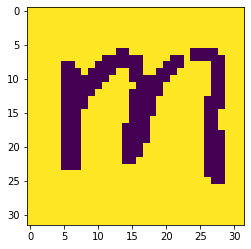

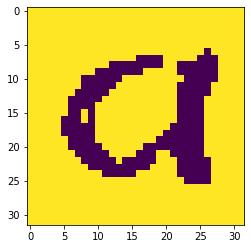

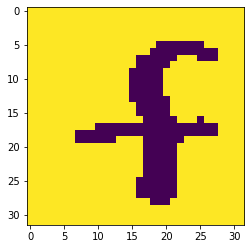

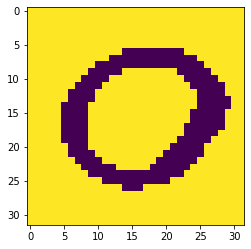

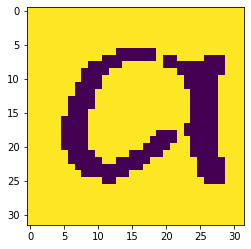

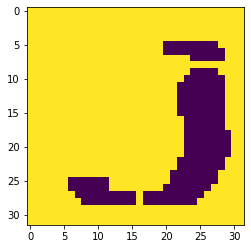

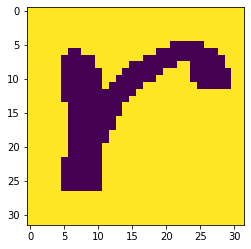

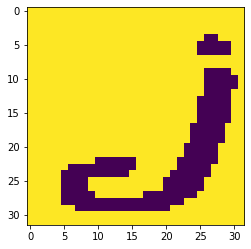

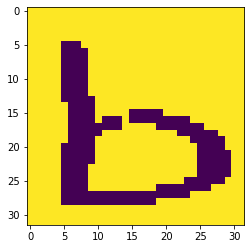

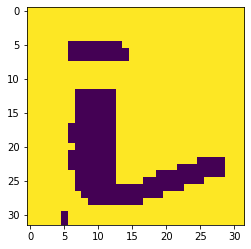

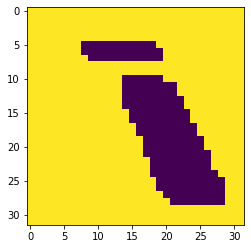

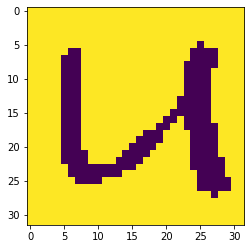

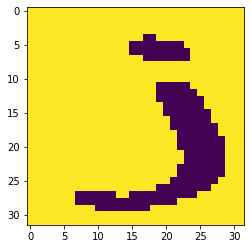

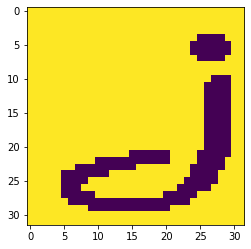

In [105]:
for c in cnts:
    area = cv2.contourArea(c)
    if area > 1000 and area < 100000:
        x,y,w,h = cv2.boundingRect(c)

        if x > 10:
            x -= 20
        if y > 10:
            y + 5
        w += 20
        h += 40

        ROI = img_cp[y:y+h, x:x+w]

        img = np.array(ROI)
        
        img = cv2.resize(img, (32, 32))
        img = preProcessing(img)
        
        img = img.reshape(1, 32, 32, 1)
        roi = cv2.resize(ROI, (32, 32), interpolation=cv2.INTER_AREA)
        roi=preProcessing(roi)
        arr = get_feature(roi)
        plt.figure()
        plt.imshow(roi)
        plt.draw()
        
        roi_hog_fd = get_feature(roi)
        classIndex = model.predict(np.array([roi_hog_fd], 'float64'))
        probVal = np.amax(model.predict_proba(np.array([roi_hog_fd], 'float64')))
        if probVal > threshold:
            cv2.rectangle(imgOriginal, (x, y), (x + w, y + h), (0, 0, 255), 3)
            cv2.putText(imgOriginal, getLetter(classIndex) + " " + str(round(probVal, 2)), (x, y+10), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 2)
        else:
            cv2.rectangle(imgOriginal, (x, y), (x + w, y + h), (0, 0, 255), 3)
            cv2.putText(imgOriginal,"-", (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 3)
cv2.imwrite('res2.jpg', imgOriginal)
cv2.namedWindow("Resulting Image with Rectangular ROIs", cv2.WINDOW_NORMAL)
cv2.imshow("Resulting Image with Rectangular ROIs", imgOriginal)
cv2.waitKey()